In [1]:
import os
from typing import List

import cv2
import numpy as np
from numpy import linalg as LA
from sympy import Matrix, Symbol

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['figure.dpi'] = 120

Note: SymPy is optional. Without `sympy`, Some cells will fail to run, but this will not affect the result as SymPy is only used to display the matrices in LaTeX.

# Task 1: 3D-2D Camera Calibration

In [2]:
path = 'Python user/stereo2012a.jpg'
img = plt.imread(path)

In [3]:
# %matplotlib qt5
# plt.figure(figsize=(12,12))
# plt.title(path)
# plt.imshow(img)
# uv = plt.ginput(n=12)
# uv = np.array(uv)
# plt.close()
# np.save('uv', uv)

In [4]:
%matplotlib inline
uv = np.load('uv.npy')

Text(0.5, 1.0, 'Python user/stereo2012a.jpg')

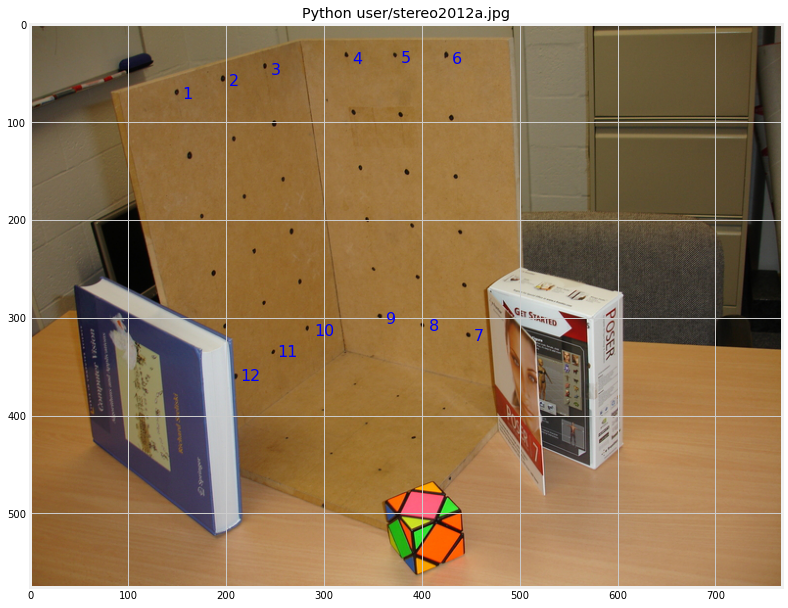

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(img)
# plt.xticks([])
# plt.yticks([])
for idx, pos in enumerate(uv, 1):
    plt.text(x=pos[0]+5, y=pos[1]+5, s=idx, color='blue', fontsize=16)
plt.title(path)

In [6]:
# sorted from 1 - 12
XYZ = np.array([
    [ 0,42,21],
    [ 0,42,14],
    [ 0,42, 7],
    [ 7,42, 0],
    [14,42, 0],
    [21,42, 0],
    [21, 7, 0],
    [14, 7, 0],
    [ 7, 7, 0],
    [ 0, 7, 7],
    [ 0, 7,14],
    [ 0, 7,21]
])

In [7]:
# x, y, z = XYZ[0]
# u, v = uv[0]

# xw = Symbol('x_w')
# yw = Symbol('y_w')
# zw = Symbol('z_w')
# u_var = Symbol('u')
# v_var = Symbol('v')
# A = Matrix([
#     [xw, yw, zw, 1, 0, 0, 0, 0, -u_var*xw, -u_var*yw, -u_var*zw, -u_var],
#     [0, 0, 0, 0, xw, yw, zw, 1, -v_var*xw, -v_var*yw, -v_var*zw, -v_var]
# ])
# A = A.subs(xw, x)
# A = A.subs(yw, y)
# A = A.subs(zw, z)
# A = A.subs(u_var, u)
# A = A.subs(v_var, v)
# A

In [8]:
def to_homogenous_coord(X: np.ndarray):
    """
    Parameters:
        X (np.ndarray): array of coordinates
    """
    n = X.shape[0]
    if len(X.shape) == 2 and 2 <= X.shape[1] <= 3:
        return np.hstack((X, np.ones(n).reshape(n, -1)))
    else:
        return X
    
def to_heterogenous_coord(X: np.ndarray):
    if len(X.shape) == 2:
        return X[:,:-1] / X[:,-1:]
    
def build_A(img_coord, world_coord):
    """Build A 2 rows at a time"""
            
    if len(img_coord) == 3:
        u, v, _ = img_coord
    else:
        u, v = img_coord
    
    if len(world_coord) == 4:
        x, y, z, _ = world_coord
    else:
        x, y, z = world_coord

    # build matrix A of 2n x 12
    A = np.array([
        [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u],
        [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v]
    ])
        
    return A

def get_A(uv: np.ndarray, xyz: np.ndarray):
    """Iteratively build matrix A"""
    n = uv.shape[0]
    A = np.vstack([build_A(uv[i], xyz[i]) for i in range(n)])
    assert A.shape == (2*n, 12)
    return A
    
def calibrate(im: np.ndarray, XYZ: np.ndarray, uv: np.ndarray):
    """
    Compute the 3x4 camera calibration matrix C such that xi = C @ Xi, where Xi is the world coordinate and xi is the image pixel coordinate

    Parameters:
        im: Image of the calibration target.
        XYZ: N x 3 array of XYZ coordinates of the calibration target points.
        uv: N x 2 array of image coordinates of the calibration target points.

    Returns:
        C (np.ndarray): 3 x 4 camera calibration matrix
    """
    assert XYZ.shape[0] >= 6
    assert uv.shape[0] == XYZ.shape[0]

    n = uv.shape[0]
    
    if uv.shape[1] == 2:
        uv = to_homogenous_coord(uv)
    
    if XYZ.shape[1] == 3:
        XYZ = to_homogenous_coord(XYZ)

    # construct matrix A and get the eigenvec corresponding to the smallest non-zero eigenvalue
    A = get_A(uv, XYZ)
    U, S, VT = LA.svd(A)
    p = VT[-1,:]
    
    # normalize p to unit length
    p = p / (p @ p)
    # p = p / p[-1]
    C = p.reshape(3, 4)
    
    return C

### Normalized DLT

In [9]:
h, w, _ = img.shape

Tnorm = np.array([
    [w+h, 0, w/2],
    [0, w+h, h/2],
    [0, 0, 1]
])

uv_norm = Tnorm @ to_homogenous_coord(uv).T
uv_norm = uv_norm.T
uv_norm.shape

(12, 3)

In [10]:
eigvals, eigvecs = LA.eig( (XYZ - XYZ.mean(0)) @ (XYZ - XYZ.mean(0)).T )
eigvals = np.diag(1 / eigvals[:3])
eigvecs = eigvecs[:3, :3]

left_component = eigvecs @ eigvals @ LA.inv(eigvecs)
right_component = -eigvecs @ eigvals @ LA.inv(eigvecs) @ XYZ.mean(0)
right_component = right_component.reshape(len(right_component), -1)

Snorm = np.hstack([left_component, right_component])
Snorm = np.vstack([Snorm, [0,0,0,1]])

XYZ_norm = Snorm @ to_homogenous_coord(XYZ).T
XYZ_norm = XYZ_norm.T
XYZ_norm.shape

(12, 4)

## 1.3 Compute Calibration Matrix P and project correspondence points to pixel coordinate system

In [11]:
XYZ = to_homogenous_coord(XYZ)
P = calibrate(img, XYZ, uv)
# P = calibrate(img, XYZ_norm, uv_norm)
# P = LA.inv(Tnorm) @ P @ Snorm

In [12]:
Matrix(np.matrix(P).round(4))

Matrix([
[ 0.0089, -0.0041, -0.0133, 0.6928],
[-0.0004, -0.0156,  0.0023, 0.7208],
[    0.0,     0.0,     0.0, 0.0021]])

In [13]:
LA.norm(P)

1.0000000000000002

In [14]:
# P = P / P[-1,-1]
# P = P / LA.norm(P)
# assert LA.norm(P) == 1
# Matrix(np.matrix(P).round(4))

In [15]:
# project coordinates from world to img
xyz_proj = P @ XYZ.T
xyz_proj = to_heterogenous_coord(xyz_proj.T)

Text(0.5, 1.0, 'Original (blue) and projected (red) points')

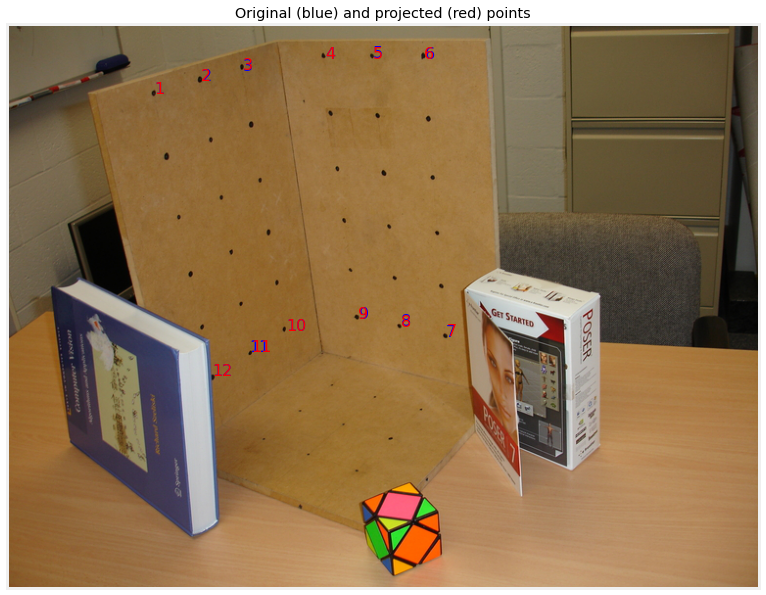

In [16]:
n = len(uv)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
for i in range(n):
    plt.text(x=uv[i][0], y=uv[i][1], s=i+1, color='blue', fontsize=16)
    plt.text(x=xyz_proj[i][0], y=xyz_proj[i][1], s=i+1, color='red', fontsize=16)
plt.title('Original (blue) and projected (red) points')

In [18]:
# distance in pixels, MSE
np.mean(np.sum(np.square(uv - xyz_proj), 1)).round(4)

0.5426

## 1.4 Extrinsic and Intrinsic Parameters

In [19]:
# %load 'Python user/vgg_KR_from_P.py'
'''
%VGG_KR_FROM_P Extract K, R from camera matrix.
%
%    [K,R,t] = VGG_KR_FROM_P(P [,noscale]) finds K, R, t such that P = K*R*[eye(3) -t].
%    It is det(R)==1.
%    K is scaled so that K(3,3)==1 and K(1,1)>0. Optional parameter noscale prevents this.
%
%    Works also generally for any P of size N-by-(N+1).
%    Works also for P of size N-by-N, then t is not computed.

% original Author: Andrew Fitzgibbon <awf@robots.ox.ac.uk> and awf
% Date: 15 May 98

% Modified by Shu.
% Date: 8 May 20
'''
import numpy as np

def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q


def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
    print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t

K, R, t = vgg_KR_from_P(P)

3 | [[ 8.90629859e-03 -4.14692138e-03 -1.33119809e-02]
 [-3.82757009e-04 -1.55974745e-02  2.25583330e-03]
 [-9.30249262e-06 -6.83349696e-06 -1.21812069e-05]]


In [20]:
Matrix(np.matrix(K).round(4))

Matrix([
[908.7838,  -1.4141, 382.2355],
[     0.0, 892.3563, 293.5467],
[     0.0,      0.0,      1.0]])

In [21]:
Matrix(np.matrix(R).round(4))

Matrix([
[ 0.8174, -0.1021,  -0.567],
[ 0.1568, -0.9076,  0.3894],
[-0.5543, -0.4072, -0.7259]])

In [22]:
Matrix(np.matrix(t).round(4))

Matrix([[76.4326, 56.7049, 85.5121]])

In [23]:
h, w, _ = img.shape

Text(0.5, 1.0, 'Principal Point (blue) and image center (red)')

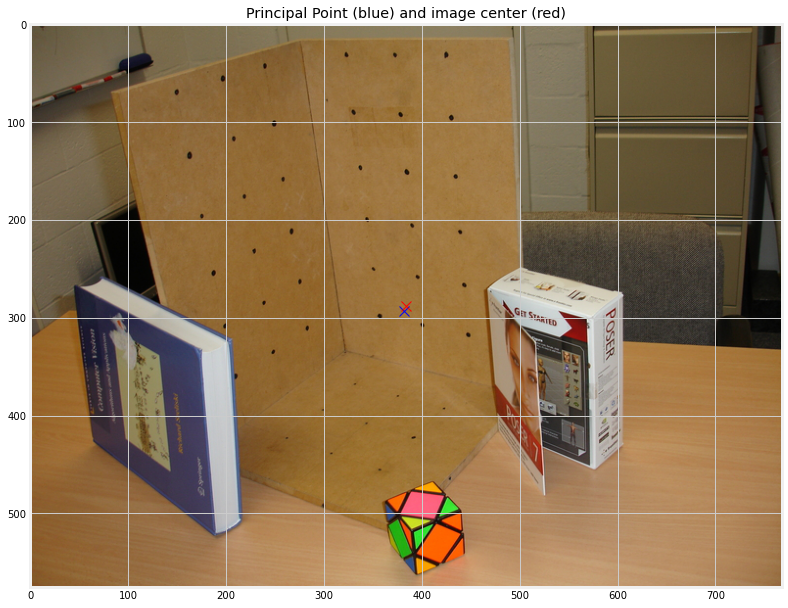

In [24]:
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.plot(K[0][2], K[1][2], marker='x', markersize=10, color='blue')
plt.plot(w/2, h/2, marker='x', markersize=10, color='red')
plt.title('Principal Point (blue) and image center (red)')

## 1.5: Focal Length and Pitch Angle

In [25]:
ax = K[0][0]
ay = K[1][1]
print('ax:', ax)
print('ay:', ay)
print('focal length:', np.mean([ax, ay]))
print('aspect ratio:', ay / ax)

ax: 908.7838201708981
ay: 892.356291375963
focal length: 900.5700557734306
aspect ratio: 0.9819236121613103


In [26]:
# theta_abs = np.arccos((np.trace(R) - 1) / 2)
# theta_abs

In [27]:
# np.pi - theta_abs

In [28]:
# np.degrees(np.pi - theta_abs)

The position, ${\displaystyle C}$, of the camera expressed in world coordinates is ${\displaystyle C=-R^{-1}T=-R^{T}T}$.

$$
\cos \theta = 
\frac{\vec{c} \cdot \vec{p}}{\left\Vert\vec{c}\right\Vert  \cdot \left\Vert\vec{p}\right\Vert}
$$

where $c, p \in \mathbb{R}^{3}$

We can get the angle using

$$
\theta = \arccos (\cos (\theta))
$$

In [29]:
C = -R.T @ t.reshape(len(t), -1)
C.T

array([[-23.96402805,  94.08800595,  83.32400034]])

In [30]:
plane = np.array([7,0,7])

In [31]:
theta = np.arccos((C.T @ plane) / (LA.norm(C) * LA.norm(plane)))
theta

array([1.23654328])

In [32]:
np.degrees(theta)

array([70.84871102])

## 1.6 Resize

Text(0.5, 1.0, 'Resized to (H/2, W/2)')

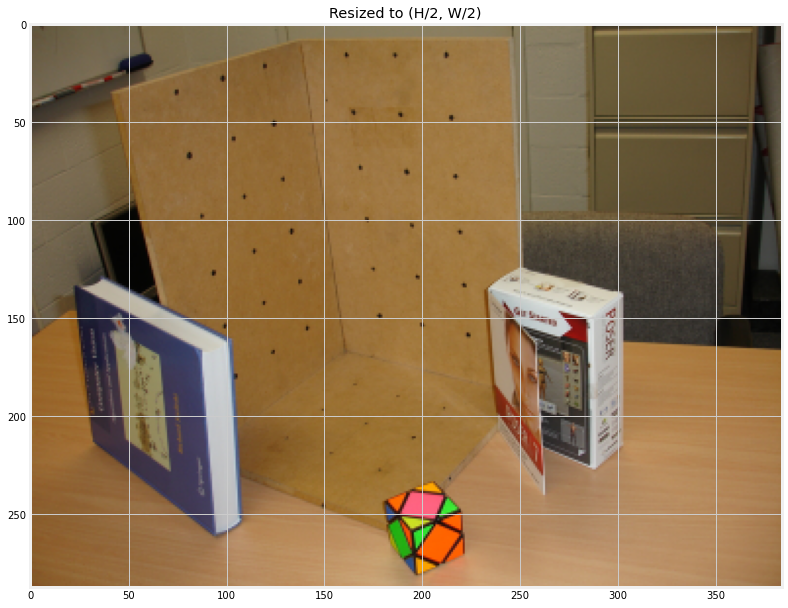

In [33]:
# resize to (H/2, W/2)
h, w, _ = img.shape
resized = cv2.resize(img, dsize=(w//2, h//2))
plt.figure(figsize=(12,12))
plt.imshow(resized)
plt.title('Resized to (H/2, W/2)')

In [34]:
img2 = resized

In [35]:
# %matplotlib qt5
# plt.figure(figsize=(12,12))
# plt.imshow(img2)
# uv2 = plt.ginput(n=12)
# uv2 = np.array(uv2)
# plt.close()
# np.save('uv2', uv2)

In [36]:
%matplotlib inline
uv2 = np.load('uv2.npy')

Text(0.5, 1.0, 'Selected correspondence points')

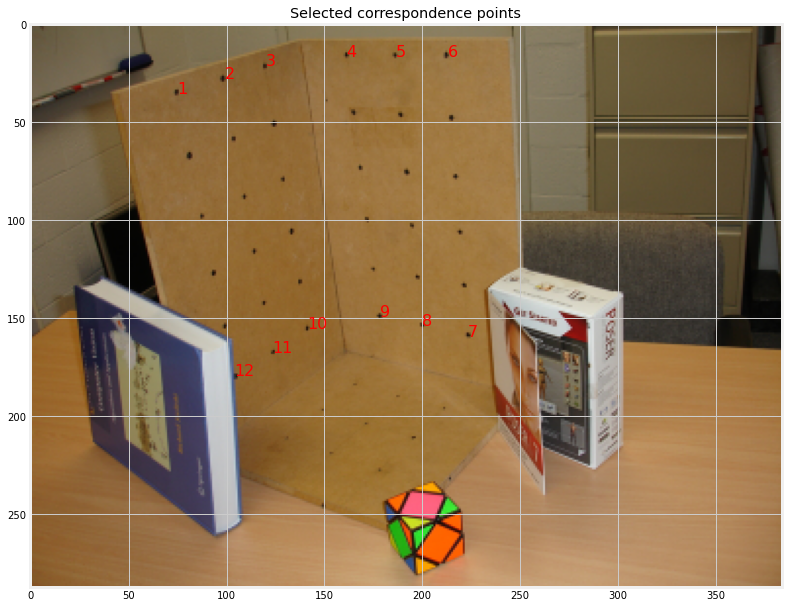

In [37]:
n = len(uv2)
plt.figure(figsize=(12,12))
plt.imshow(img2)
for i in range(n):
    plt.text(x=uv2[i][0], y=uv2[i][1], s=i+1, color='red', fontsize=16)
# plt.xticks([])
# plt.yticks([])
plt.title('Selected correspondence points')

In [38]:
XYZ2 = to_homogenous_coord(XYZ)
P2 = calibrate(img2, XYZ2, uv2)
K2, R2, t2 = vgg_KR_from_P(P2)

3 | [[ 8.90660663e-03 -4.14295362e-03 -1.32672048e-02]
 [-1.54871877e-04 -1.57692989e-02  2.55101048e-03]
 [-1.93034663e-05 -1.40615018e-05 -2.49253860e-05]]


In [39]:
Matrix(np.matrix(P2).round(4))

Matrix([
[ 0.0089, -0.0041, -0.0133,  0.693],
[-0.0002, -0.0158,  0.0026, 0.7206],
[    0.0,     0.0,     0.0, 0.0043]])

In [40]:
Matrix(np.matrix(K2).round(4))

Matrix([
[442.1749,   1.4406, 182.1194],
[     0.0, 442.5788, 135.2311],
[     0.0,      0.0,      1.0]])

In [41]:
Matrix(np.matrix(R2).round(4))

Matrix([
[ 0.8133, -0.1007, -0.5731],
[ 0.1607, -0.9077,  0.3876],
[-0.5592, -0.4073, -0.7221]])

In [42]:
Matrix(np.matrix(t2).round(4))

Matrix([[73.4314, 58.4466, 83.2765]])

# Task 2: Two-View DLT based Homography Estimation

## 2.1 Code, images used, and correspondence points

In [43]:
l = plt.imread('Python user/Left.jpg')
r = plt.imread('Python user/Right.jpg')

In [44]:
n = 6

In [45]:
# %matplotlib qt5
# plt.figure(figsize=(12,12))
# plt.imshow(l)
# uv_left = np.array(plt.ginput(n=n))
# plt.close()
# np.save('uv_left', uv_left)

In [46]:
uv_left = np.load('uv_left.npy')

Text(0.5, 1.0, 'Selected correspondence points')

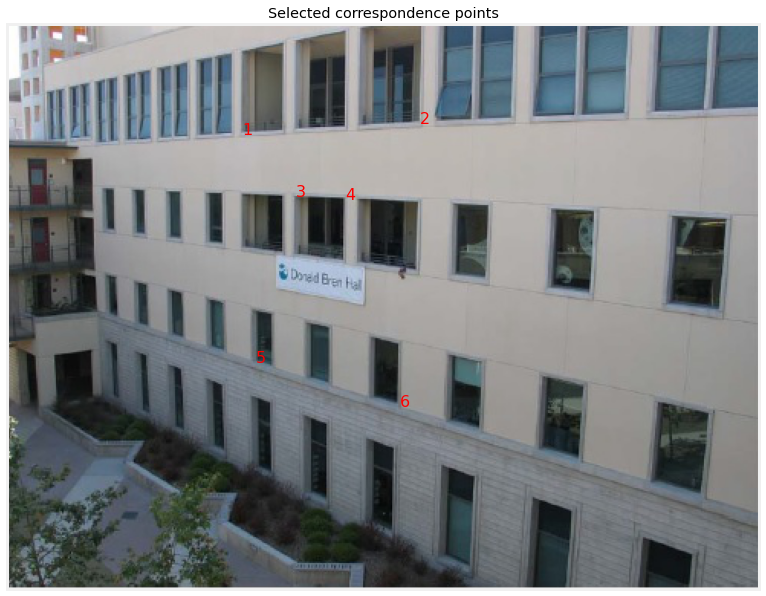

In [47]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.imshow(l)
for i in range(n):
    plt.text(x=uv_left[i][0], y=uv_left[i][1], s=i+1, color='red', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Selected correspondence points')

In [48]:
# %matplotlib qt5
# plt.figure(figsize=(12,12))
# plt.imshow(r)
# uv_right = np.array(plt.ginput(n=n))
# plt.close()
# np.save('uv_right', uv_right)

In [49]:
uv_right = np.load('uv_right.npy')

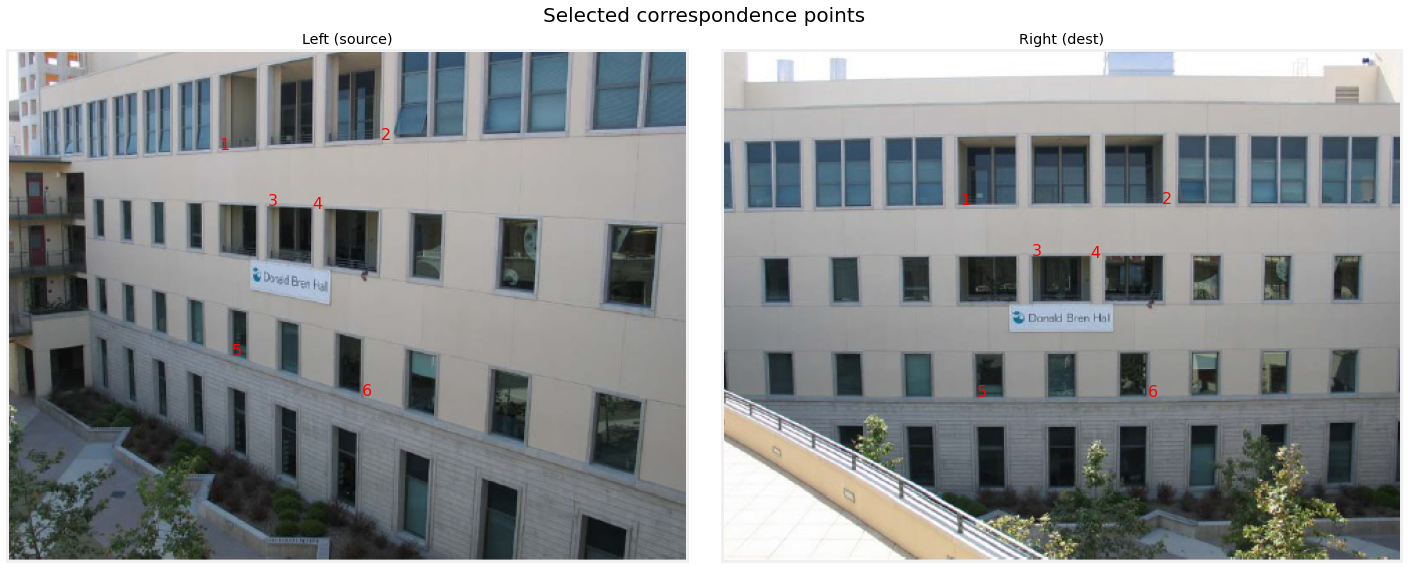

In [50]:
%matplotlib inline
plt.figure(figsize=(20, 8))
plt.suptitle('Selected correspondence points', fontsize=20)

# 1
plt.subplot(1, 2, 1)
plt.imshow(l)
for i in range(n):
    plt.text(x=uv_left[i][0], y=uv_left[i][1], s=i+1, color='red', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Left (source)')

# 2
plt.subplot(1, 2, 2)
plt.imshow(r)
for i in range(n):
    plt.text(x=uv_right[i][0], y=uv_right[i][1], s=i+1, color='red', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Right (dest)')

plt.tight_layout()

In [51]:
def homography(u2Trans: List[float], v2Trans: List[float], uBase: List[float], vBase: List[float]):
    """
    Computes the homography H applying the Direct Linear Transformation
    
    Parameters:
        u2Trans : Vectors with coordinates u and v of the transformed image
        v2Trans : point (p')
        uBase : vectors with coordinates u and v of the original base
        vBase : image point p
    """
    uv_src = np.vstack([u2Trans, v2Trans]).T
    uv_dest = np.vstack([uBase, vBase]).T
    return _homography(uv_src, uv_dest)

def _homography(uv_src: np.ndarray, uv_dest: np.ndarray):
    assert uv_src.shape[0] >= 6
    assert uv_src.shape[0] == uv_dest.shape[0]

    if uv_src.shape[1] == 2:
        uv_src = to_homogenous_coord(uv_src)
    
    if uv_dest.shape[1] == 2:
        uv_dest = to_homogenous_coord(uv_dest)
        
    A = get_A(uv_src, uv_dest)
    U, S, VT = LA.svd(A)
    p = VT[-1]
    
    # normalize p to unit length
    p = p / (p @ p)
    H = p.reshape(3, 3)
    
    return H

def get_A(uv_src: np.ndarray, uv_dest: np.ndarray):
    """Iteratively build matrix A for homography"""
    n = uv_src.shape[0]
    A = np.vstack([build_A_homography(uv_src[i], uv_dest[i]) for i in range(n)])
    assert A.shape == (2*n, 9)
    return A
    
def build_A_homography(uv_src, uv_dest):
    """Build A 2 rows at a time"""
    assert len(uv_src) == 3 and len(uv_dest) == 3
    
    u, v, _ = uv_src
    x, y, _ = uv_dest

    A = np.array([
        [u, v, 1, 0, 0, 0, -x*u, -x*v, -x],
        [0, 0, 0, u, v, 1, -y*u, -y*v, -y]
    ])

    return A

## 2.2 Compute homography matrix H

In [52]:
H = homography(
    u2Trans=uv_left[:, 0].tolist(), 
    v2Trans=uv_left[:, 1].tolist(), 
    uBase=uv_right[:, 0].tolist(), 
    vBase=uv_right[:, 1].tolist()
)

In [53]:
Matrix(np.matrix(H).round(4))

Matrix([
[-0.0149,  0.0004,  0.9997],
[-0.0024, -0.0065,  0.0169],
[    0.0,     0.0, -0.0047]])

## 2.3 Warp image using H

In [54]:
x, y, _ = r.shape
size = (y, x)
l_warped = cv2.warpPerspective(l, H, dsize=size)

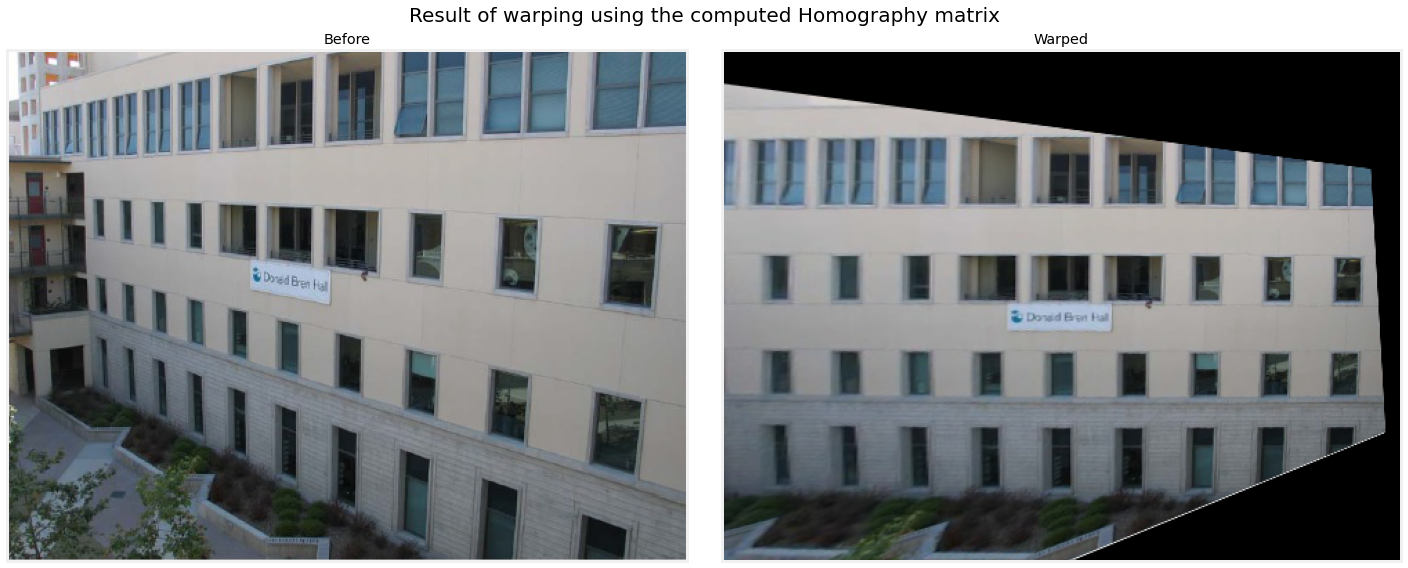

In [55]:
plt.figure(figsize=(20, 8))
plt.suptitle('Result of warping using the computed Homography matrix', fontsize=20)

# 1
plt.subplot(1, 2, 1)
plt.imshow(l)
plt.xticks([])
plt.yticks([])
plt.title('Before')

# 2
plt.subplot(1, 2, 2)
plt.imshow(l_warped)
plt.xticks([])
plt.yticks([])
plt.title('Warped')

plt.tight_layout()

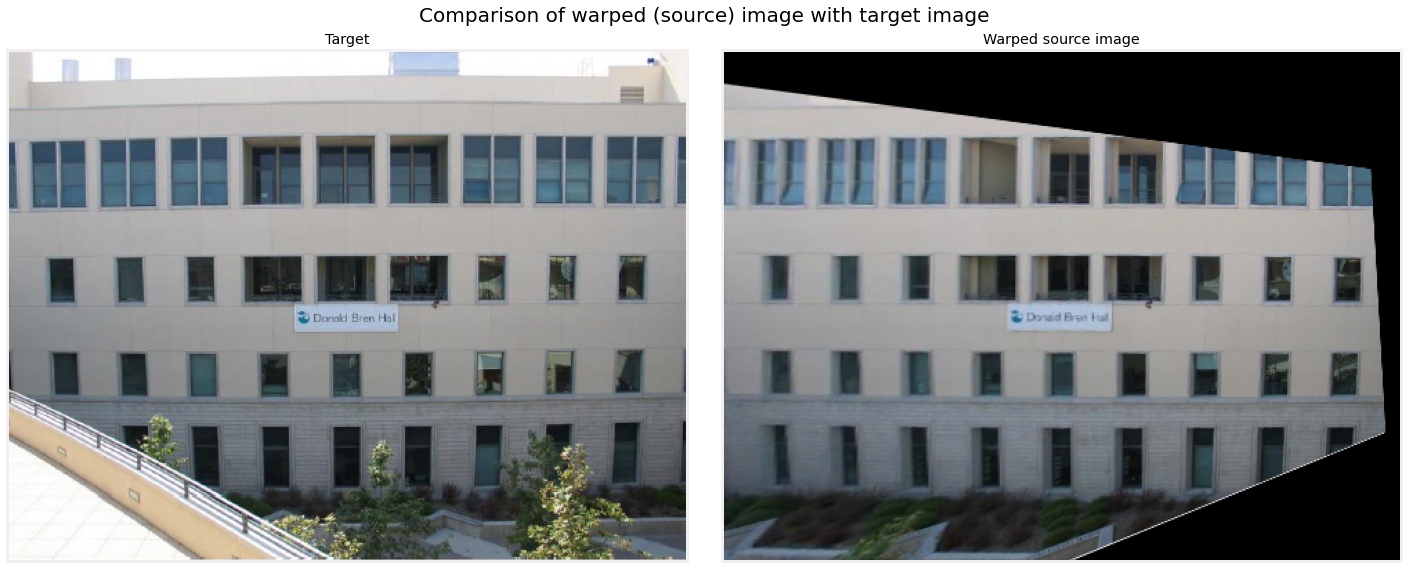

In [56]:
plt.figure(figsize=(20, 8))
plt.suptitle('Comparison of warped (source) image with target image', fontsize=20)

plt.subplot(1, 2, 1)
plt.imshow(r)
plt.xticks([])
plt.yticks([])
plt.title('Target')

plt.subplot(1, 2, 2)
plt.imshow(l_warped)
plt.xticks([])
plt.yticks([])
plt.title('Warped source image')

plt.tight_layout()

In [57]:
# project img coordinates using H
uv_left = to_homogenous_coord(uv_left)
uv_left_proj = H @ uv_left.T
uv_left_proj = to_heterogenous_coord(uv_left_proj.T)

Text(0.5, 1.0, 'Original and warped Correspondence points')

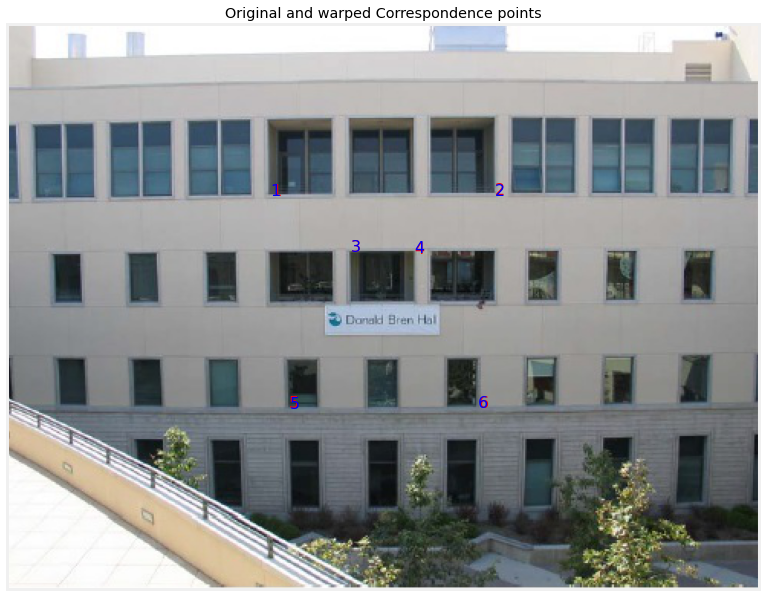

In [58]:
plt.figure(figsize=(12,12))
plt.imshow(r)
plt.xticks([])
plt.yticks([])
for i in range(n):
    plt.text(x=uv_right[i][0], y=uv_right[i][1], s=i+1, color='red', fontsize=16)
    plt.text(x=uv_left_proj[i][0], y=uv_left_proj[i][1], s=i+1, color='blue', fontsize=16)
plt.title('Original and warped Correspondence points')

In [59]:
# distance in pixels, MSE
np.mean(np.sum(np.square(uv_right - uv_left_proj), 1)).round(4)

0.3556